# Mustererkennung/Machine Learning - Assignment 2 Solution

##### Questions to julian.stastny@fu-berlin.de

In [1]:
import numpy as np
from numpy.linalg import pinv
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
training_data = np.array(pd.read_csv('Data/zip.train', sep=' ', header=None))
test_data = np.array(pd.read_csv('Data/zip.test', sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

In [3]:
class Classifier:
  
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)
    
    def confusion_matrix(self, labels, predictions):
        size = len(set(labels))
        matrix = np.zeros((size, size))
        for correct, predicted in zip(labels.astype(int), predictions.astype(int)):
            matrix[correct][predicted] += 1
        return matrix

### A naive first attempt: Using the numerical values of the labels

In [4]:
class LeastSquares:

    def fit(self, X, y):
        self.w = pinv(X.T@X)@X.T@y
    
    def predict(self, X):
        predictions = X@self.w
        return predictions

In [5]:
class NaiveAttempt(Classifier):
    
    def __init__(self):
        self.model = LeastSquares()
    
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        predictions = self.model.predict(X)
        predictions = np.around(predictions, decimals=0)
        predictions[predictions>9] = 9 
        predictions[predictions<0] = 0
        return predictions

In [6]:
model = NaiveAttempt()

In [7]:
model.fit(X_train, y_train)

In [8]:
predictions = model.predict(X_test)

In [9]:
model.accuracy(y_test, predictions)

0.25460886895864476

Better than random, but really bad!

In [10]:
model.confusion_matrix(y_test, predictions)

array([[128., 108.,  65.,  39.,  12.,   4.,   3.,   0.,   0.,   0.],
       [  6., 119.,  84.,  35.,  14.,   3.,   3.,   0.,   0.,   0.],
       [ 14.,  20.,  41.,  43.,  46.,  24.,   7.,   3.,   0.,   0.],
       [  2.,  10.,  24.,  39.,  41.,  37.,  11.,   2.,   0.,   0.],
       [  0.,   1.,   5.,  12.,  40.,  46.,  40.,  39.,  14.,   3.],
       [  3.,  10.,  17.,  23.,  33.,  31.,  28.,  11.,   3.,   1.],
       [  0.,   5.,   8.,  16.,  47.,  52.,  36.,   4.,   2.,   0.],
       [  0.,   0.,   1.,   3.,  10.,  20.,  45.,  47.,  18.,   3.],
       [  2.,   1.,   3.,   4.,  24.,  30.,  50.,  34.,  14.,   4.],
       [  0.,   0.,   0.,   2.,   9.,  17.,  22.,  55.,  56.,  16.]])

## One vs One

In [11]:
class OneVsOne(Classifier):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        classes = list(set(y))
        self.num_classes = len(classes)
        assert classes == list(range(self.num_classes)) # We need the labels to be 0,...,num_classes-1
        self.binary_classifiers = self.build_all_binary_classifiers()
        
    def predict(self, X):
        votes = np.zeros((self.num_classes, len(X)))
        binary_predictions = self.predict_all_binary(X)
        
        for (i,j), prediction in binary_predictions.items():
            votes[i] += (prediction < 0.5).astype(int)
            votes[j] += (prediction >= 0.5).astype(int)
        
        predictions = np.argmax(votes, axis=0)
        return predictions
        
    def predict_all_binary(self, X):
        binary_predictions = {}
        for i in range(self.num_classes):
            for j in range(i+1, self.num_classes):
                prediction = self.binary_classifiers[(i,j)].predict(X)
                binary_predictions[(i,j)] = prediction
        return binary_predictions
    
    def build_all_binary_classifiers(self):
        binary_classifiers = {}
        
        for i in range(self.num_classes):
            for j in range(i+1, self.num_classes):
                
                X_train, y_train = self.create_subset(i, j)
                binary_classifiers[(i,j)] = self.build_one_binary_classifier(
                    X_train, y_train)
                
        return binary_classifiers
    
    def build_one_binary_classifier(self, X_train, y_train):
        classifier = self.model()
        classifier.fit(X_train, y_train)
        return classifier
        
    def create_subset(self, i, j):
        X_i = self.X[self.y == i]
        X_j = self.X[self.y == j]
        X = np.concatenate((X_i, X_j))
        y = [0] * len(X_i) + [1] * len(X_j)
        return X, y

In [12]:
model = OneVsOne(LeastSquares)

In [13]:
model.fit(X_train, y_train)

In [14]:
predictions = model.predict(X_test)

In [15]:
model.accuracy(y_test, predictions)

0.9162929745889388

In [16]:
model.confusion_matrix(y_test, predictions)

array([[343.,   0.,   4.,   1.,   3.,   1.,   1.,   1.,   5.,   0.],
       [  0., 257.,   0.,   0.,   4.,   0.,   3.,   0.,   0.,   0.],
       [  6.,   0., 176.,   2.,   7.,   1.,   0.,   1.,   5.,   0.],
       [  4.,   1.,   3., 141.,   1.,  10.,   0.,   1.,   4.,   1.],
       [  1.,   2.,   5.,   0., 185.,   2.,   2.,   1.,   0.,   2.],
       [  4.,   0.,   0.,   9.,   1., 142.,   0.,   0.,   2.,   2.],
       [  4.,   0.,   3.,   0.,   4.,   4., 153.,   0.,   2.,   0.],
       [  0.,   0.,   2.,   0.,   7.,   0.,   0., 135.,   1.,   2.],
       [  8.,   0.,   6.,   7.,   3.,   3.,   1.,   0., 138.,   0.],
       [  0.,   0.,   0.,   2.,   5.,   0.,   0.,   1.,   0., 169.]])

In [17]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 255 - sample_digits[i].reshape((16, 16))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

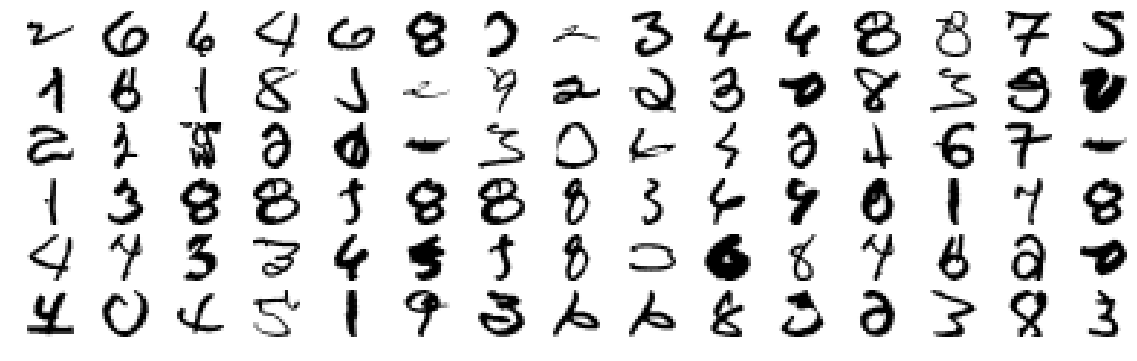

In [18]:
misclassified = X_test[(predictions != y_test)]
show_numbers(misclassified)

We are doing much better, but:  
1) Still worse than kNN  
2) The misclassified numbers are mostly well readable for a human!